In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, TransformerMixin

Train data shape: (1460, 80)
Column types:
 object     43
int64      34
float64     3
Name: count, dtype: int64
Missing values per column:
 LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


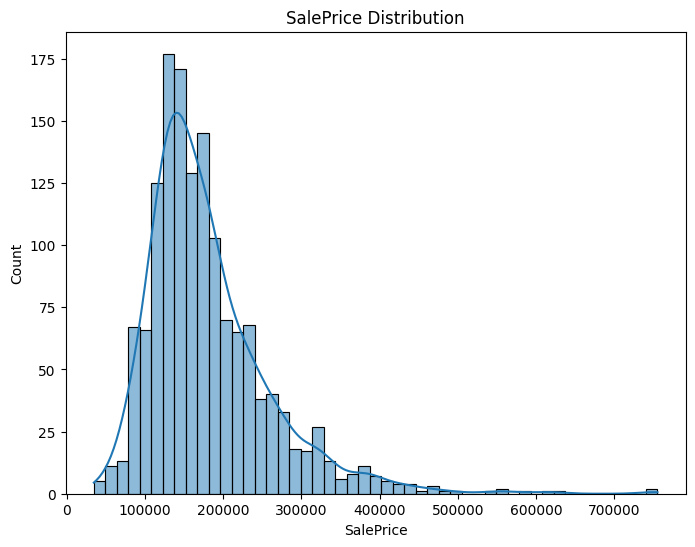

In [14]:
# Load datasets
train_data = pd.read_csv('Data/train.csv', index_col='Id')
test_data = pd.read_csv('Data/test.csv', index_col='Id')

# Analyze train data structure
print("Train data shape:", train_data.shape)
print("Column types:\n", train_data.dtypes.value_counts())
print("Missing values per column:\n", train_data.isnull().sum()[train_data.isnull().sum() > 0])

# Visualize target variable distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()

# Log-transform target due to skewness
y = np.log1p(train_data['SalePrice'])
X_train_raw = train_data.drop('SalePrice', axis=1)
X_test_raw = test_data

Train shape: (1460, 79)
Test shape: (1459, 79)
Missing values:
 LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


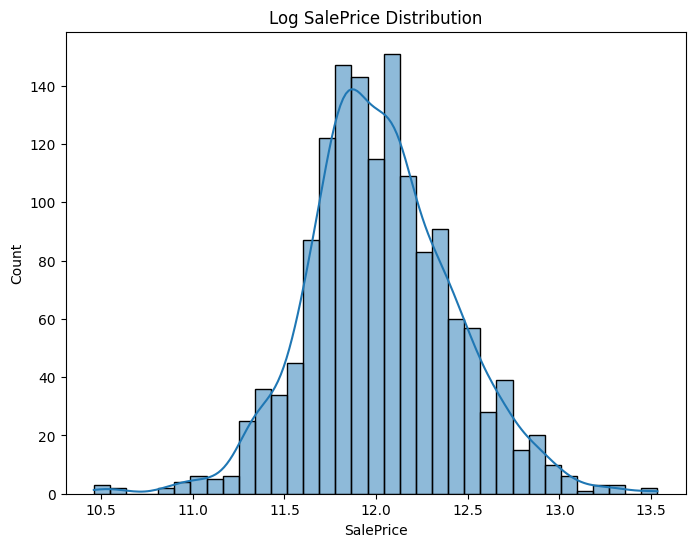

Rows after outlier removal: 1360


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [15]:


# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Reading Data
train_data = pd.read_csv('Data/train.csv', index_col='Id')
test_data = pd.read_csv('Data/test.csv', index_col='Id')
y = np.log1p(train_data['SalePrice'])  # Log-transform target
train_data = train_data.drop('SalePrice', axis=1)

# Step 2: Exploring Data/Data Insight
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_data.select_dtypes(include=['object']).columns
print("Missing values:\n", train_data.isnull().sum()[train_data.isnull().sum() > 0])
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True)
plt.title('Log SalePrice Distribution')
plt.show()

# Correlation analysis for initial feature insight
corr = pd.concat([train_data[numerical_cols], y], axis=1).corr()
top_correlated = corr['SalePrice'].abs().sort_values(ascending=False)[1:11].index

# Step 3: Cleansing Data
special_cases = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu']
for col in special_cases:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')

num_imputer = SimpleImputer(strategy='median')
train_data[numerical_cols] = num_imputer.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = num_imputer.transform(test_data[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_cols] = cat_imputer.fit_transform(train_data[categorical_cols])
test_data[categorical_cols] = cat_imputer.transform(test_data[categorical_cols])

# Step 4: Outlier Detection and Removal
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

outlier_cols = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF']  # Validated high-impact features
train_data_clean = remove_outliers(train_data.copy(), outlier_cols)
y_clean = y.loc[train_data_clean.index]
print("Rows after outlier removal:", train_data_clean.shape[0])

# Step 5: Data Transformation (Normalize/Rescale)
skewness = train_data_clean[numerical_cols].skew()
skewed_cols = skewness[abs(skewness) > 0.75].index
for col in skewed_cols:
    train_data_clean[col] = np.log1p(train_data_clean[col])
    test_data[col] = np.log1p(test_data[col])

scaler = StandardScaler()
train_data_clean[numerical_cols] = scaler.fit_transform(train_data_clean[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# Step 6: Categorical to Numerical
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_encoded = pd.DataFrame(encoder.fit_transform(train_data_clean[categorical_cols]), 
                            index=train_data_clean.index)
test_encoded = pd.DataFrame(encoder.transform(test_data[categorical_cols]), 
                           index=test_data.index)
X_train_full = pd.concat([train_data_clean[numerical_cols], train_encoded], axis=1)
X_test_full = pd.concat([test_data[numerical_cols], test_encoded], axis=1)

# Step 7: Dimensionality Reduction (PCA)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_full)
X_test_pca = pca.transform(X_test_full)
print("PCA components:", X_train_pca.shape[1])
ridge = Ridge()
pca_score = np.mean(np.sqrt(-cross_val_score(ridge, X_train_pca, y_clean, cv=5, 
                                            scoring='neg_mean_squared_error')))
print("PCA RMSLE:", pca_score)

# Step 8: Handling Imbalanced Data (Not applicable for regression, skipped)

# Step 9: Feature Selection
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_pca, y_clean)
selected_idx = np.where(lasso_cv.coef_ != 0)[0]
X_train_selected = X_train_pca[:, selected_idx]
X_test_selected = X_test_pca[:, selected_idx]
print("Selected features:", X_train_selected.shape[1])

# Step 10: Data Splitting
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_selected, y_clean, test_size=0.2, random_state=42)

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['TotalSqFeet'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['TotalBathroom'] = X['FullBath'] + X['BsmtFullBath'] + 0.5 * (X['HalfBath'] + X['BsmtHalfBath'])
        X['HouseAge'] = X['YrSold'] - X['YearBuilt']
        X['Remodeled'] = (X['YearRemodAdd'] != X['YearBuilt']).astype(int)
        X['IsNew'] = (X['YrSold'] == X['YearBuilt']).astype(int)
        return X

# Apply feature engineering
fe = FeatureEngineer()
X_train_fe = fe.transform(X_train_raw)
X_test_fe = fe.transform(X_test_raw)

# Validate engineered features
new_features = ['TotalSqFeet', 'TotalBathroom', 'HouseAge', 'Remodeled', 'IsNew']
for feature in new_features:
    corr = X_train_fe[feature].corr(y)
    print(f"Correlation of {feature} with SalePrice: {corr:.4f}")

Correlation of TotalSqFeet with SalePrice: 0.7773
Correlation of TotalBathroom with SalePrice: 0.6730
Correlation of HouseAge with SalePrice: -0.5873
Correlation of Remodeled with SalePrice: -0.0738
Correlation of IsNew with SalePrice: 0.2205


In [ ]:
class ImputerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
    
    def fit(self, X, y=None):
        self.numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
        self.categorical_cols = X.select_dtypes(include=['object']).columns
        self.num_imputer.fit(X[self.numerical_cols])
        self.cat_imputer.fit(X[self.categorical_cols])
        return self
    
    def transform(self, X):
        X_num = pd.DataFrame(self.num_imputer.transform(X[self.numerical_cols]), 
                             columns=self.numerical_cols, index=X.index)
        X_cat = pd.DataFrame(self.cat_imputer.transform(X[self.categorical_cols]), 
                             columns=self.categorical_cols, index=X.index)
        return pd.concat([X_num, X_cat], axis=1)

class EncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        try:
            self.onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        except TypeError:
            self.onehot = OneHotEncoder(handle_unknown='ignore')
    
    def fit(self, X, y=None):
        self.categorical_cols = X.select_dtypes(include=['object']).columns
        self.onehot.fit(X[self.categorical_cols])
        return self
    
    def transform(self, X):
        X_cat_encoded = pd.DataFrame(self.onehot.transform(X[self.categorical_cols]),
                                     columns=self.onehot.get_feature_names_out(),
                                     index=X.index)
        X_num = X.select_dtypes(exclude=['object'])
        return pd.concat([X_num, X_cat_encoded], axis=1)

class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.scaler.transform(X), columns=X.columns, index=X.index)

# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('impute', ImputerTransformer()),
    ('encode', EncoderTransformer()),
    ('scale', ScalerTransformer())
])

# Preprocess data
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train_fe)
X_test_preprocessed = preprocessing_pipeline.transform(X_test_fe)

/home/vscode/.local/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
# Use LassoCV for feature selection
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_preprocessed, y)

# Select features with non-zero coefficients
selected_features = X_train_preprocessed.columns[lasso_cv.coef_ != 0]
print("Number of selected features:", len(selected_features))

X_train_selected = X_train_preprocessed[selected_features]
X_test_selected = X_test_preprocessed[selected_features]

Number of selected features: 84


In [ ]:
class AveragingModel(BaseEstimator, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=1)

# Define individual models
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.00065, max_iter=100000, tol=0.001)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)
lgb = LGBMRegressor(objective='regression', random_state=42, verbose=-1)

# Create ensemble
ensemble = AveragingModel(models=[ridge, lasso, xgb, lgb])

In [ ]:
# Evaluate using cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmsle_scores = []

for train_idx, val_idx in kf.split(X_train_selected):
    X_tr, X_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    ensemble.fit(X_tr, y_tr)
    pred_log = ensemble.predict(X_val)
    rmsle = np.sqrt(mean_squared_error(y_val, pred_log))
    rmsle_scores.append(rmsle)

print("Average RMSLE:", np.mean(rmsle_scores))

Average RMSLE: 0.1259227127068289


In [ ]:
# Train on full dataset
ensemble.fit(X_train_selected, y)

# Predict on test set
pred_log = ensemble.predict(X_test_selected)
pred = np.expm1(pred_log)

# Create submission file
submission = pd.DataFrame({'Id': test_data.index, 'SalePrice': pred})
submission.to_csv('submission.csv', index=False)